# Randomly mutates amino acids based on their codon usage
  1. obtain protein sequence
  2. convert AA -> mRNA choosing at random a codon to represent each AA
  3. Exclude peptides that contain noncanonical start sites or stop codon readthrough ("X") 
  4. Download and paste in 5'UTR and 3'UTR sequence to complete the mRNA sequence

In [1]:
import pandas as pd
import os
import numpy as np
import glob
from collections import defaultdict
import random

In [2]:
input_dir = '04_codon_mutation/inputs/'
output_dir = '04_codon_mutation/outputs/'

ensembl_peptide_fa = os.path.join(input_dir, 'human_ensembl110_peptides.fa')
cdna_3utr_file = os.path.join(input_dir, 'human_ensembl_cdna_3UTR.txt')
cdna_5utr_file = os.path.join(input_dir, 'human_ensembl_cdna_5UTR.txt')
output_mutated_sequences_file = os.path.join(output_dir, "codon_mutated_sequences_human.fasta")

# 1. Get peptide sequences from biomart
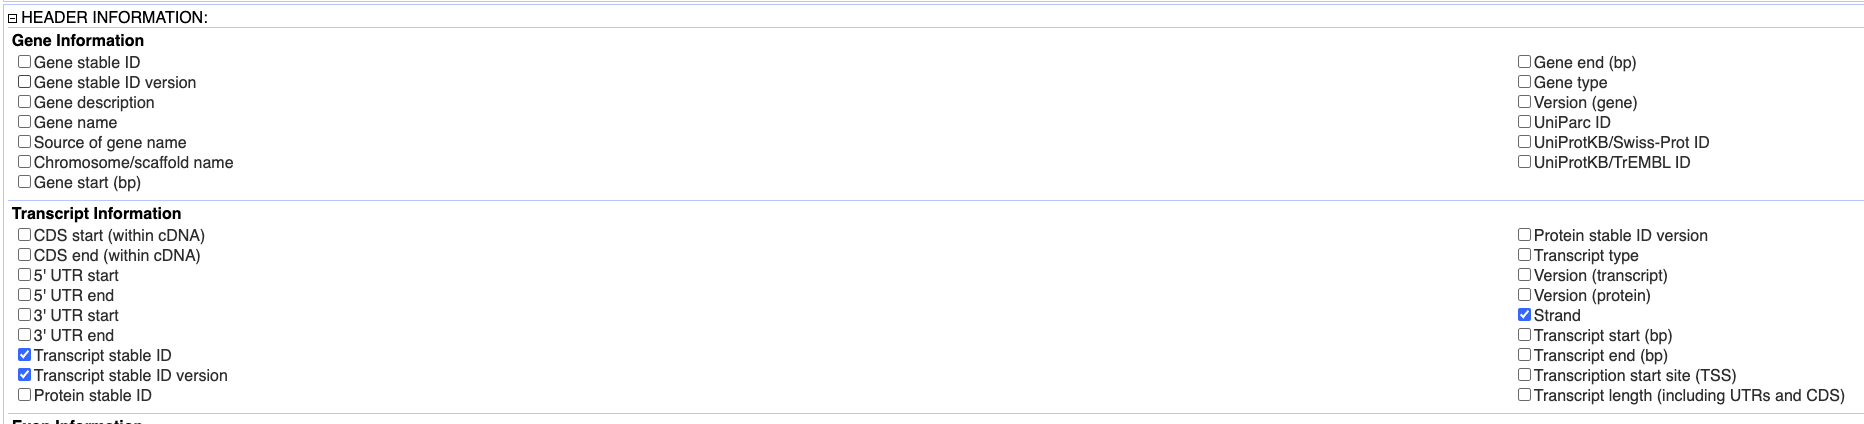

# Note: peptide and dna sequences are already in proper orientation.
- "M" always at the first position of the peptide, stop codon always last
- Download these from ensembl.org

In [3]:
peptides = defaultdict(list)
# with open(os.path.join(input_dir, 'peptides.fa'), 'r') as f:  # mice  149194 transcripts
with open(ensembl_peptide_fa, 'r') as f:  # human  276905 transcripts
    for line in f:
        if line.startswith('>'):
            key = line[1:].rstrip().split('|')[0]
        else:
            peptides[key].append(line.rstrip())

for key, seqs in peptides.items():
    peptides[key] = ''.join(seqs)
    
print(f"Read in {len(peptides.keys())} transcripts")

Read in 276905 transcripts


In [4]:
# test
for key, seqs in peptides.items():
    if seqs != 'Sequence unavailable':
        print(key, seqs)
        break

ENST00000001008 MTAEEMKATESGAQSAPLPMEGVDISPKQDEGVLKVIKREGTGTEMPMIGDRVFVHYTGWLLDGTKFDSSLDRKDKFSFDLGKGEVIKAWDIAIATMKVGEVCHITCKPEYAYGSAGSPPKIPPNATLVFEVELFEFKGEDLTEEEDGGIIRRIQTRGEGYAKPNEGAIVEVALEGYYKDKLFDQRELRFEIGEGENLDLPYGLERAIQRMEKGEHSIVYLKPSYAFGSVGKEKFQIPPNAELKYELHLKSFEKAKESWEMNSEEKLEQSTIVKERGTVYFKEGKYKQALLQYKKIVSWLEYESSFSNEEAQKAQALRLASHLNLAMCHLKLQAFSAAIESCNKALELDSNNEKGLFRRGEAHLAVNDFELARADFQKVLQLYPNNKAAKTQLAVCQQRIRRQLAREKKLYANMFERLAEEENKAKAEASSGDHPTDTEMKEEQKSNTAGSQSQVETEA*


In [5]:
def aa2codon(aa):
    """
    RANDOMLY returns a codon based on amino acid input.
    """
    D = {
      "F": ["TTT", "TTC"],
      "L": ["TTA", "TTG", "CTT", "CTC", "CTA", "CTG"],
      "I": ["ATT", "ATC", "ATA"],
      "M": ["ATG"],  # Start codon
      "V": ["GTT", "GTC", "GTA", "GTG"],
      "Y": ["TAT", "TAC"],
      "*": ["TAA", "TAG", "TGA"],  # Stop codons
      "H": ["CAT", "CAC"],
      "Q": ["CAA", "CAG"],
      "T": ["ACT", "ACC", "ACA", "ACG"],
      "A": ["GCT", "GCC", "GCA", "GCG"],
      "S": ["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
      "R": ["AGA", "AGG", "CGT", "CGC", "CGA", "CGG"],
      "G": ["GGT", "GGC", "GGA", "GGG"],
      "P": ["CCT", "CCC", "CCA", "CCG"],
      "C": ["TGC", "TGT"],
      "W": ["TGG"],
      "D": ["GAT", "GAC"],
      "E": ["GAA", "GAG"],
      "K": ["AAA", "AAG"],
      "N": ["AAT", "AAC"],
      "X": ["X"],
      "U": ["TAA", "TAG", "TGA"]
    }
    codons = D[aa]
    rand = random.randint(0,len(codons)-1)
    return codons[rand]

for i in range(0, 10):
    print(aa2codon("N"), sep=",", end=" ")

AAT AAC AAT AAC AAC AAT AAT AAT AAT AAT 

In [6]:
def peptide2sequence(peptide):
    """
    Applies aa2codon across a sequence of amino acids
    """
    sequence = ""
    for aa in peptide:
        codon = aa2codon(aa)
        sequence += codon
            
    return sequence

for i in range(0, 10):
    print(peptide2sequence("MSI"))

ATGTCCATC
ATGTCGATA
ATGTCAATC
ATGTCGATC
ATGAGTATT
ATGTCAATA
ATGTCAATT
ATGTCCATA
ATGTCTATA
ATGTCGATA


In [7]:
cds = {}
for tx_id, peptide in peptides.items():
    if peptide != "Sequence unavailable":
        try:
            cds[tx_id] = peptide2sequence(peptide.upper())
        except Exception as e:
            print(e, peptide.upper(), key)

In [8]:
peptide2sequence("MRRA")

'ATGCGACGTGCG'

### Obtain 5'UTR and 3'UTR fasta file to concatenate to transcript
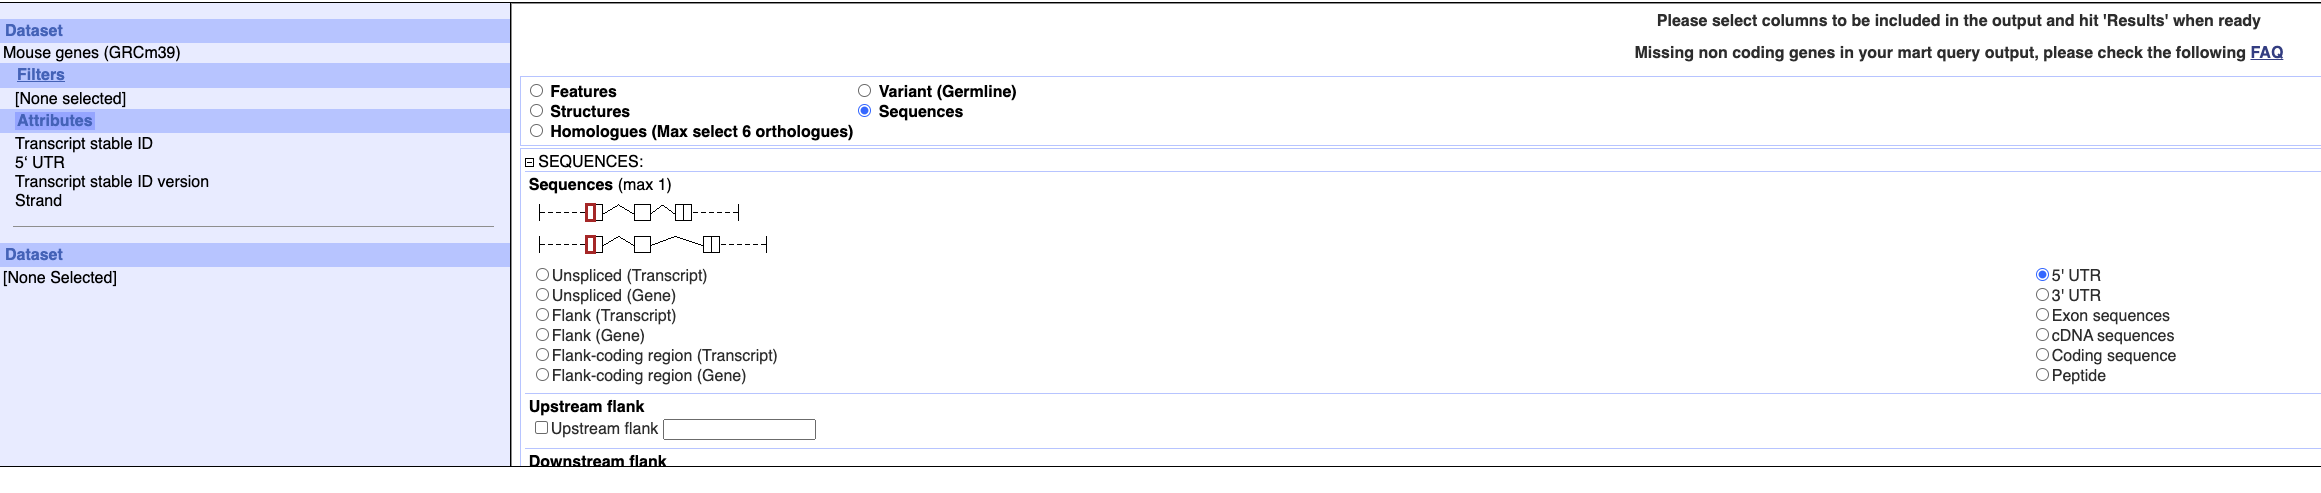

In [10]:
three_prime_utrs = defaultdict(list)
five_prime_utrs = defaultdict(list)

# with open(os.path.join(input_dir, 'mm39_3utrs.from_karen.fasta'), 'r') as f:
with open(cdna_3utr_file, 'r') as f:
    for line in f:
        if line.startswith('>'):
            key = line[1:].rstrip().split('|')[2]
        else:
            three_prime_utrs[key].append(line.rstrip())

for key, seqs in three_prime_utrs.items():
    three_prime_utrs[key] = ''.join(seqs)

# with open(os.path.join(input_dir, 'mm39_5utrs.from_karen.fasta'), 'r') as f:
with open(cdna_5utr_file, 'r') as f:
    for line in f:
        if line.startswith('>'):
            key = line[1:].rstrip().split('|')[2]
        else:
            five_prime_utrs[key].append(line.rstrip())

for key, seqs in five_prime_utrs.items():
    five_prime_utrs[key] = ''.join(seqs)

# mouse: Read in 149443 5'UTRs and 149443 3'UTRs
# human: Read in 274578 5'UTRs and 274578 3'UTRs

print(f"Read in {len(five_prime_utrs.keys())} 5'UTRs and {len(three_prime_utrs.keys())} 3'UTRs")  

Read in 274578 5'UTRs and 274578 3'UTRs


In [11]:
five_prime_utrs['ENSMUST00000000094']  # test

[]

In [12]:
def compile_mrna(transcript_id, five_prime_utrs, cds, three_prime_utrs):
    """
    'pastes' together UTR sequences with the mutated CDS sequence. 
    For now, we don't expect X in transcripts (I'm filtering them out above) but 
    in theory this function would replace X in sequences with stop signal (*)
    """
    has_5utr = False
    has_3utr = False
    transcript = ""
    five_prime_utr = ""
    three_prime_utr = ""
    
    if type(five_prime_utrs[transcript_id]) != list and five_prime_utrs[transcript_id] != "Sequence unavailable":
        five_prime_utr = five_prime_utrs[transcript_id]
    if type(three_prime_utrs[transcript_id]) != list and three_prime_utrs[transcript_id] != "Sequence unavailable":
        three_prime_utr = three_prime_utrs[transcript_id]

    coding_sequence = cds[transcript_id]
    # if coding_sequence.startswith('X'):
    #     try:
    #         assert five_prime_utr == ""
    #     except AssertionError:
    #         print(transcript_id, five_prime_utr)
    
    # if "X" in coding_sequence:
    #     coding_sequence = coding_sequence.replace("X", aa2codon("*"))  # stop codon readthrough
        
    transcript = five_prime_utr + coding_sequence + three_prime_utr
    try:
        assert "X" not in transcript  # ensure we've accounted for any offsets/weird frameshifts in coding sequence
    except AssertionError:
        # print(transcript_id)
        return None
    return transcript


In [13]:
transcripts = {}
for transcript in cds.keys():
    try:
        tx = compile_mrna(transcript, five_prime_utrs, cds, three_prime_utrs)
        if tx is not None:  # has an "X" so we'll exclude
            transcripts[transcript] = tx
    except TypeError:
        print(five_prime_utrs[transcript], transcript)
        raise

In [14]:
# write fasta
with open(output_mutated_sequences_file, 'w') as o:
    for transcript_id, sequence in transcripts.items():
        o.write(f">{transcript_id}\n{sequence}\n")

# sanity checks/scratch space